In [1]:
import sys

import custom_transforms as CT
import torchvision.transforms as T
from AudioMNIST import AudioMNIST
from IPython.display import Audio
import librosa

from scipy import signal
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian
from scipy.signal import stft, istft

In [2]:
import os
from glob import glob

import librosa
from torch.utils.data import Dataset

class AudioMNIST(Dataset):
    def __init__(self, 
                 root,
                 target_sample_rate = 22050,
                 duration = None,
                 transform = None):
        super(AudioMNIST, self).__init__()
        self.root = root
        self.target_sample_rate = target_sample_rate
        self.duration = duration
        self.transform = transform
        self.wav_files = glob('*/*.wav', root_dir=root, recursive=True)

    def __getitem__(self, index):
        file_name = os.path.join(self.root, self.wav_files[index])
        label = int(os.path.basename(file_name)[0])
        waveform, _ = librosa.load(file_name, sr=self.target_sample_rate, duration=self.duration)
        
        if self.transform is not None:
            x = self.transform(waveform)

        return x, label
    
    
        
    def __len__(self):
        return len(self.wav_files)


In [6]:
sample_rate=22050
n_fft=512
root = '../Data'

transforms = [
    CT.TrimSilence(5),
    CT.FixLength(30000)
]

dataset = AudioMNIST(root, target_sample_rate=sample_rate, transform=T.Compose(transforms))

In [7]:
x, _ = dataset[0]
Audio(data=x, rate=sample_rate)

In [8]:
x.shape

(30000,)

In [9]:
import scipy
import numpy as np
#(x.shape- nperseg) % (nperseg-noverlap) == 0)

f, t, Zxx = scipy.signal.stft(x, sample_rate, nperseg = n_fft/2, noverlap = n_fft/4, window='hann')
        # get amplitude
Zxx = Zxx[0:128, :-1]
#Zxx = np.abs(Zxx[0:128, :-1])
#Zxx = np.atleast_3d(Zxx).transpose(2,0,1)
        # convert to decibel
#Zxx = librosa.amplitude_to_db(Zxx, ref = np.max)

In [10]:
Zxx.shape

(128, 235)

In [11]:
def complex_to_2d(tensor: np.ndarray) -> np.ndarray:
    """Converts complex IQ to two channels representing real and imaginary

    Args:
        tensor (:class:`numpy.ndarray`):
            (batch_size, vector_length, ...)-sized tensor.

    Returns:
        transformed (:class:`numpy.ndarray`):
            Expanded vectors
    """

    new_tensor = np.zeros((2, tensor.shape[0]), dtype=np.float64)
    new_tensor[0] = np.real(tensor).astype(np.float64)
    new_tensor[1] = np.imag(tensor).astype(np.float64)
    return new_tensor


In [12]:
datapoint = complex_to_2d(Zxx.flatten())

In [14]:
datapoint=datapoint.reshape(2,128,235)

In [15]:
datapoint.shape

(2, 128, 235)

(1, 128, 235)


Text(0.5, 1.0, 'Real')

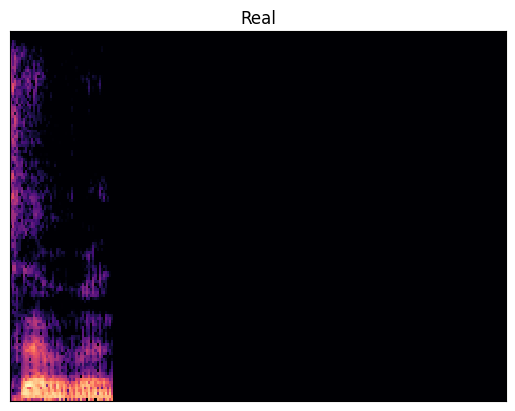

In [16]:
Zxxx = np.abs(Zxx)
Zxxx = np.atleast_3d(Zxxx).transpose(2,0,1)
        # convert to decibel
print(Zxxx.shape)
Zxxx = librosa.amplitude_to_db(Zxxx, ref = np.max)
import matplotlib.pyplot as plt
librosa.display.specshow(Zxxx[0])
plt.title("Real")

In [17]:
def twod_to_complex(tensor: np.ndarray):
    """Converts complex IQ to two channels representing real and imaginary

    Args:
        tensor (:class:`numpy.ndarray`):
            (batch_size, vector_length, ...)-sized tensor.

    Returns:
        transformed (:class:`numpy.ndarray`):
            Expanded vectors
    """
    tmp_tensor = tensor.reshape(2, tensor.shape[1]*tensor.shape[2])
    new_tensor = np.zeros((1, tmp_tensor.shape[1]), dtype=np.complex64)
    new_tensor[0] = tmp_tensor[0,:]+ 1j * tmp_tensor[1,:]
    new_tensor=new_tensor.reshape(1, tensor.shape[1],tensor.shape[2])
    return new_tensor


In [18]:
Zxx_rec=twod_to_complex(datapoint)
Zxx_rec.shape

(1, 128, 235)

/tmp/ipykernel_947637/1845499812.py:1: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  Zxxx = librosa.amplitude_to_db(Zxx_rec, ref = np.max)


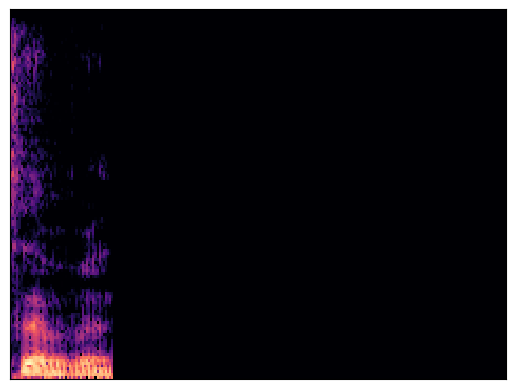

In [19]:
Zxxx = librosa.amplitude_to_db(Zxx_rec, ref = np.max)
import matplotlib.pyplot as plt
librosa.display.specshow(Zxxx[0])

In [20]:

_,x = scipy.signal.istft(Zxx_rec, sample_rate)
        # get amplitude
x.shape

(1, 29718)

In [21]:
Audio(data=x, rate=sample_rate)